In [1]:
import pandas as pd
from datetime import datetime
df = pd.read_csv('ATP.csv')

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (3,5,6,7,8,9,12,14,15,16,17,18,19,22,24,25,26,28,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
df = df[df['tourney_date'] != 'tourney_date']
df['winner_id'] = pd.to_numeric(df['winner_id'])
df['loser_id'] = pd.to_numeric(df['loser_id'])

## Most majors by players

In [3]:
# Most majors
gs_winner_df = df[(df['tourney_level'] == 'G') & (df['round'] == 'F')]
grouped = gs_winner_df.groupby('winner_name').count().sort_values('winner_id', ascending= False).ix[:,0]
grouped

winner_name
Roger Federer            18
Rafael Nadal             14
Pete Sampras             14
Novak Djokovic           12
Bjorn Borg               11
Ivan Lendl                8
Andre Agassi              8
Jimmy Connors             8
Mats Wilander             7
John Mcenroe              7
Stefan Edberg             6
Boris Becker              6
John Newcombe             5
Rod Laver                 5
Jim Courier               4
Ken Rosewall              4
Guillermo Vilas           4
Gustavo Kuerten           3
Jan Kodes                 3
Arthur Ashe               3
Andy Murray               3
Stanislas Wawrinka        3
Patrick Rafter            2
Lleyton Hewitt            2
Sergi Bruguera            2
Stan Smith                2
Marat Safin               2
Yevgeny Kafelnikov        2
Johan Kriek               2
Ilie Nastase              2
Albert Costa              1
Richard Krajicek          1
Yannick Noah              1
Thomas Muster             1
Thomas Johansson          1
Andres G

## Create initial player ELO table

In [4]:
# List of all players in the data
winner_names = df[['winner_name','winner_id']].drop_duplicates().set_index('winner_id')
loser_names = df[['loser_name','loser_id']].drop_duplicates().rename(index=str, columns={"loser_name": "winner_name", "loser_id": "winner_id"}).set_index('winner_id')

In [5]:
# List of all players in the data
winner_names = df[['winner_name','winner_id']].drop_duplicates()
loser_names = df[['loser_name','loser_id']].drop_duplicates().rename(index=str, columns={"loser_name": "winner_name", "loser_id": "winner_id"})

player_unique_list = pd.concat([winner_names, loser_names])

player_unique_list['winner_id'] = pd.to_numeric(player_unique_list['winner_id'])

player_unique_list = player_unique_list.drop_duplicates(['winner_name','winner_id']).set_index('winner_id')

player_unique_list['elo_score'] = 1000

In [6]:
player_unique_list[player_unique_list['winner_name'] == 'Roger Federer']

,winner_name,elo_score
winner_id,,
103819,Roger Federer,1000


In [7]:
player_unique_list.sort_values('elo_score', ascending = False)

,winner_name,elo_score
winner_id,,
110023,Richard Coulthard,1000
110059,James Ferguson,1000
106951,Eric Baer,1000
106634,Bob Brien,1000
107378,John Burrman,1000
110022,Steve Wedderburn,1000
107898,Osamu Ishiguro,1000
125708,Song Kean Tan,1000
125691,Georges Logelin,1000


## Create time series from the data

In [8]:
from dateutil.parser import parse

In [9]:
# Parse timestamp from tourney date
df['timestamp'] = df.loc[:,'tourney_date'].apply(lambda x: parse(str(x)))

K-s based on Tourney level:
G: major
D: Davis Cup
M: Major tournament
C: Challanger
F: Final
A: regular tournament

In [10]:
# Setting timestamp as index
df = df.set_index(df['timestamp'])

In [11]:
columns_needed_for_elo = [
    'tourney_id',
    'tourney_name',
    'draw_size',
    'tourney_level',
    'winner_id',
    'winner_name',
    'loser_id',
    'loser_name',
    'score',
    'best_of',
    'round'
]

In [12]:
elo_df = df[columns_needed_for_elo]

In [13]:
len(elo_df)

163965

## Calculating score difference to reward straight set wins in ELO.

In [14]:
def score_diff(score, best_of):
    if ((len(score.split()) == 3) and (best_of == 5)) or ((len(score.split()) == 2) and (best_of == 3)):
        return 1.75
    elif (len(score.split()) == 4) and (best_of == 5):
        return 1.5
    else:
        return 1

In [15]:
elo_df['score_diff'] = elo_df.apply(lambda x: score_diff(str(x['score']), x['best_of']), axis = 1)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Calculate ELO ratings

In [16]:
def expected(A, B):
    """
    Calculate expected score of A in a match against B
    :param A: Elo rating for player A
    :param B: Elo rating for player B
    """
    return 1 / (1 + 10 ** ((B - A) / 400))


def elo(old, expected, score, score_diff, k=30):
    """
    Calculate the new Elo rating for a player
    :param old: The previous Elo rating
    :param exp: The expected score for this match
    :param score: The actual score for this match
    :param k: The k-factor for Elo (default: 32)
    :param score_diff: calculated score diff for result
    """
    return old + k * score_diff * (score - expected)

In [17]:
player_unique_list.head()

,winner_name,elo_score
winner_id,,
110023,Richard Coulthard,1000
109803,John Brown,1000
100257,Ross Case,1000
100105,Allan Stone,1000
109966,Warren Jacques,1000


In [18]:
elo_df.tail()

,tourney_id,tourney_name,draw_size,tourney_level,winner_id,winner_name,loser_id,loser_name,score,best_of,round,score_diff
timestamp,,,,,,,,,,,,
2017-02-03,2017-M-DC-2017-WG-M-RUS-SRB-01,Davis Cup WG R1: RUS vs SRB,4,D,106421,Daniil Medvedev,102800,Nenad Zimonjic,Walkover,3,RR,1.00
2017-02-03,2017-M-DC-2017-WG-M-SUI-USA-01,Davis Cup WG R1: SUI vs USA,4,D,106058,Jack Sock,103843,Marco Chiudinelli,6-4 6-3 6-1,5,RR,1.75
2017-02-03,2017-M-DC-2017-WG-M-SUI-USA-01,Davis Cup WG R1: SUI vs USA,4,D,104545,John Isner,105967,Henri Laaksonen,4-6 6-2 6-2 7-6(1),5,RR,1.50
2017-02-03,2017-M-DC-2017-WG-M-SUI-USA-01,Davis Cup WG R1: SUI vs USA,4,D,105023,Sam Querrey,104847,Adrien Bossel,6-3 7-5,3,RR,1.75
2017-02-03,2017-M-DC-2017-WG-M-SUI-USA-01,Davis Cup WG R1: SUI vs USA,4,D,105449,Steve Johnson,134472,Antoine Bellier,6-4 6-3,3,RR,1.75


In [19]:
def elo_calc(row):
    prev_elo_winner = player_unique_list.loc[row['winner_id'],'elo_score']
    prev_elo_loser = player_unique_list.loc[row['loser_id'],'elo_score']
    
    exp_win = expected(prev_elo_winner, prev_elo_loser)
    exp_lose = expected(prev_elo_loser, prev_elo_winner)
    
    elo_winner = elo(prev_elo_winner, exp_win, 1, row['score_diff'])
    elo_loser = elo(prev_elo_loser, exp_lose, 0, row['score_diff'])
    
    player_unique_list.loc[row['winner_id'],'elo_score'] = elo_winner
    player_unique_list.loc[row['loser_id'],'elo_score'] = elo_loser
    
    #return [elo_winner, elo_loser]

    return pd.Series({'elo_winner': elo_winner, 'elo_loser':elo_loser}) 

In [20]:
elo_scores = elo_df.apply(lambda x: elo_calc(x), axis = 1)

In [21]:
elo_df['elo_loser'] = elo_scores.iloc[:,0]
elo_df['elo_winner'] = elo_scores.iloc[:,1]

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [22]:
roger_federer = elo_df[elo_df['winner_name'] == 'Roger Federer']['elo_winner']
novak_djokovic = elo_df[elo_df['winner_name'] == 'Novak Djokovic']['elo_winner']
rafael_nadal = elo_df[elo_df['winner_name'] == 'Rafael Nadal']['elo_winner']

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

In [24]:
roger_federer = roger_federer.groupby(level=0).mean()
novak_djokovic = novak_djokovic.groupby(level=0).mean()
rafael_nadal = rafael_nadal.groupby(level=0).mean()

In [25]:
#roger_federer = roger_federer[datetime(2015,1,1):datetime(2016,1,1)]
#novak_djokovic = novak_djokovic[datetime(2015,1,1):datetime(2016,1,1)]
#rafael_nadal = rafael_nadal[datetime(2015,1,1):datetime(2016,1,1)]

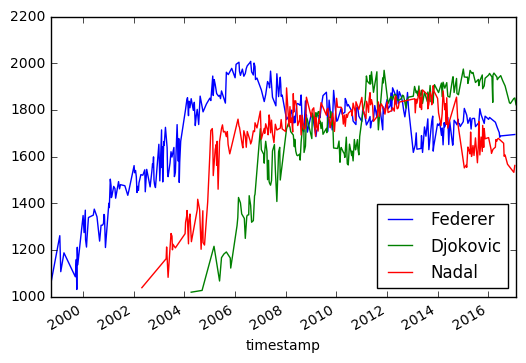

In [26]:
roger_federer.plot(label= 'Federer')
novak_djokovic.plot(label= 'Djokovic')
rafael_nadal.plot(label= 'Nadal')
plt.legend(loc='best')

## GS winner comparison

In [50]:
grouped[grouped > 2].index.values.tolist()

['Roger Federer',
 'Rafael Nadal',
 'Pete Sampras',
 'Novak Djokovic',
 'Bjorn Borg',
 'Ivan Lendl',
 'Andre Agassi',
 'Jimmy Connors',
 'Mats Wilander',
 'John Mcenroe',
 'Stefan Edberg',
 'Boris Becker',
 'John Newcombe',
 'Rod Laver',
 'Jim Courier',
 'Ken Rosewall',
 'Guillermo Vilas',
 'Gustavo Kuerten',
 'Jan Kodes',
 'Arthur Ashe',
 'Andy Murray',
 'Stanislas Wawrinka']

In [52]:
gs_winner_list = grouped[grouped > 2].index.values.tolist()

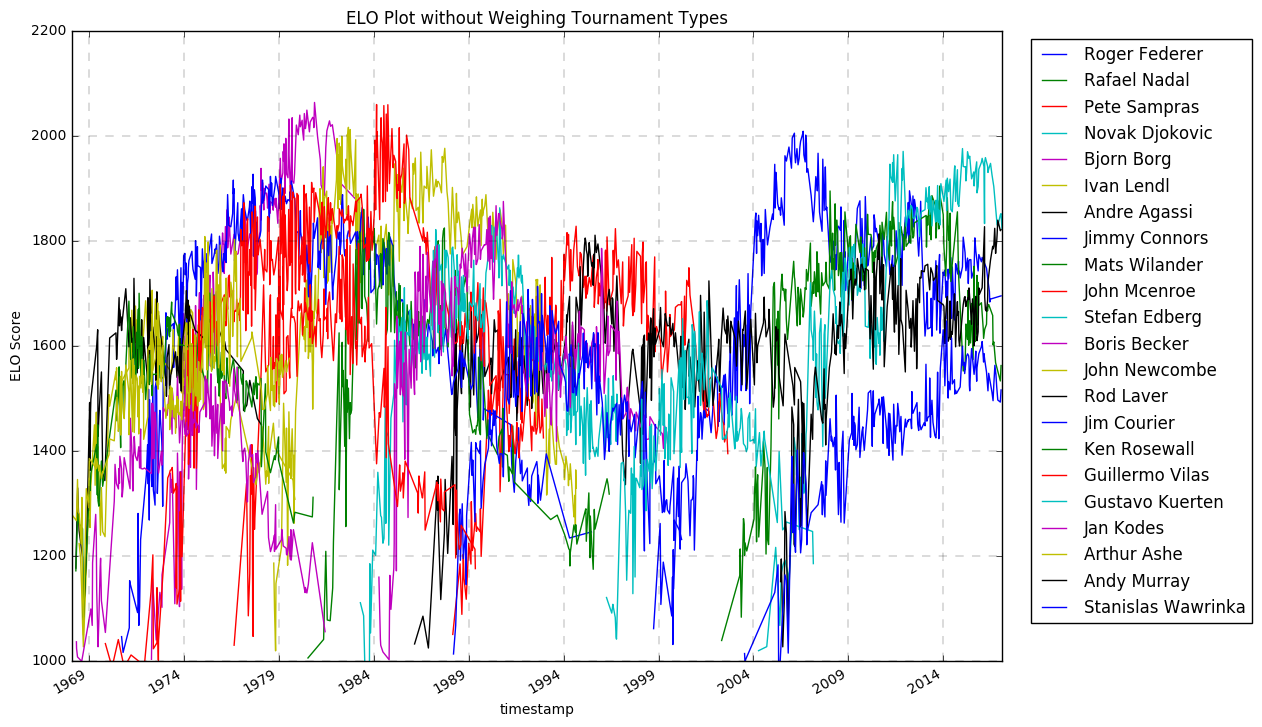

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.set_title('ELO Plot without Weighing Tournament Types')
ax.set_xlabel('Year')
ax.set_ylabel('ELO Score')
ax.set_ylim([1000, 2200])

for player in gs_winner_list:
    player_inst = elo_df[elo_df['winner_name'] == player]['elo_winner']
    player_inst = player_inst.groupby(level=0).mean()
    player_inst.plot(label= player)

plt.grid(b=True, which='major', color='k', linestyle='--', linewidth = .2)
plt.legend(loc=9, bbox_to_anchor=(1.15, 1))

## Taking Majors into Account with K-score Weighing

K-s based on Tourney level:
G: major
D: Davis Cup
M: Major tournament
C: Challanger
F: Final
A: regular tournament

In [105]:
def elo_calc_with_k(row):
    prev_elo_winner = player_unique_list.loc[row['winner_id'],'elo_score']
    prev_elo_loser = player_unique_list.loc[row['loser_id'],'elo_score']
    
    exp_win = expected(prev_elo_winner, prev_elo_loser)
    exp_lose = expected(prev_elo_loser, prev_elo_winner)
    
    if row['tourney_level'] == 'G':
        k = 50
    elif row['tourney_level'] == 'F':
        k = 40
    elif row['tourney_level'] == 'M':
        k = 35
    else:
        k = 30
    
    elo_winner = elo(prev_elo_winner, exp_win, 1, row['score_diff'], k)
    elo_loser = elo(prev_elo_loser, exp_lose, 0, row['score_diff'], k)
    
    player_unique_list.loc[row['winner_id'],'elo_score'] = elo_winner
    player_unique_list.loc[row['loser_id'],'elo_score'] = elo_loser
    
    #return [elo_winner, elo_loser]

    return pd.Series({'elo_winner': elo_winner, 'elo_loser':elo_loser}) 

In [106]:
elo_df_gs = df[columns_needed_for_elo]
elo_df_gs['score_diff'] = elo_df_gs.apply(lambda x: score_diff(str(x['score']), x['best_of']), axis = 1)
elo_scores_gs = elo_df_gs.apply(lambda x: elo_calc_with_k(x), axis = 1)
elo_df_gs['elo_loser'] = elo_scores_gs.iloc[:,0]
elo_df_gs['elo_winner'] = elo_scores_gs.iloc[:,1]

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata

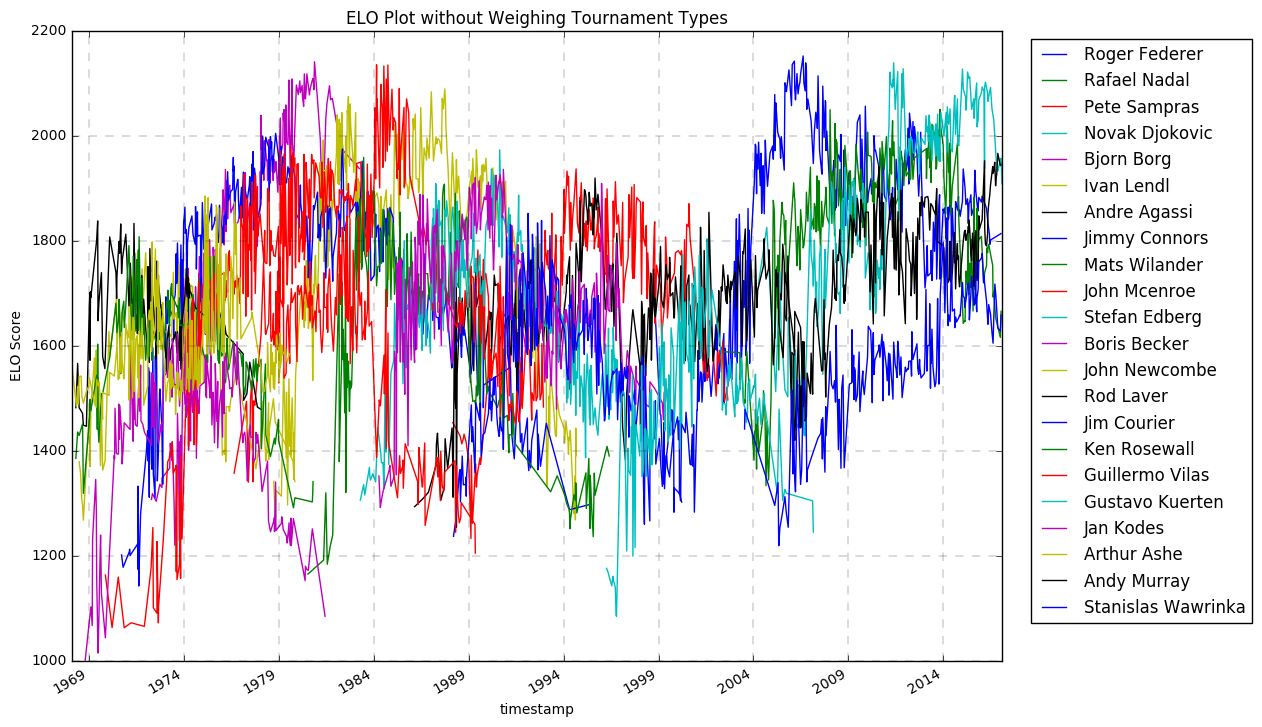

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
ax.set_title('ELO Plot with Weighing Tournament Types')
ax.set_xlabel('Year')
ax.set_ylabel('ELO Score')
ax.set_ylim([1000, 2200])

for player in gs_winner_list:
    player_inst = elo_df_gs[elo_df_gs['winner_name'] == player]['elo_winner']
    player_inst = player_inst.groupby(level=0).mean()
    player_inst.plot(label= player)

plt.grid(b=True, which='major', color='k', linestyle='--', linewidth = .2)
plt.legend(loc=9, bbox_to_anchor=(1.15, 1))